In [1]:
import sys
import os
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline
from matplotlib.pylab import style
style.use('ggplot')
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
from statsmodels.tsa.stattools import adfuller 
from arch.unitroot import ADF
from statsmodels.stats.diagnostic import acorr_ljungbox 
from statsmodels.graphics.api import qqplot
import time
import datetime
pd.set_option('display.float_format', lambda x: '%.5f' % x) 
np.set_printoptions(precision=5, suppress=True) 
plt.rcParams['font.family'] = ['sans-serif']
plt.rcParams['font.sans-serif'] = ['Heiti TC']

In [2]:
#read data
file_path = '/Users/gali/Desktop/dsmp-2024-group15/Python files/SARIMAX april/SARIMAX_asks.csv'
ask = pd.read_csv(file_path)
print(ask)
ask['adjusted_time_hours'] = pd.to_timedelta(ask['adjusted_time_hours'], unit='h')
start_date = pd.to_datetime('2025-01-01')
ask['datetime'] = start_date + ask['adjusted_time_hours']
ask.set_index('datetime', inplace=True)
ask = ask.drop('adjusted_time_hours',axis = 1)
ask = ask.drop('Type',axis = 1)
print(ask)

     Type  adjusted_time_hours     Price
0     ask              0.00000 259.05878
1     ask              1.00000 257.92273
2     ask              2.00000 266.82759
3     ask              3.00000 280.17647
4     ask              4.00000 283.92644
...   ...                  ...       ...
1058  ask           1058.00000 115.22624
1059  ask           1059.00000 115.32450
1060  ask           1060.00000 113.81467
1061  ask           1061.00000 114.35305
1062  ask           1062.00000 114.18095

[1063 rows x 3 columns]
                        Price
datetime                     
2025-01-01 00:00:00 259.05878
2025-01-01 01:00:00 257.92273
2025-01-01 02:00:00 266.82759
2025-01-01 03:00:00 280.17647
2025-01-01 04:00:00 283.92644
...                       ...
2025-02-14 02:00:00 115.22624
2025-02-14 03:00:00 115.32450
2025-02-14 04:00:00 113.81467
2025-02-14 05:00:00 114.35305
2025-02-14 06:00:00 114.18095

[1063 rows x 1 columns]


In [ ]:
#return the latest transaction price at the given time(no longer necessary)
def sel_time(t):
    #filter the data before the given time
    filtered_df = tape0701[(tape0701['time'] <= t)]

    # find the latest time point
    max_time_row = filtered_df.loc[filtered_df['time'].idxmax()]

    # get the correspondant price
    max_amount_value = max_time_row['price']

    print(max_amount_value)
    return(max_amount_value)

df = pd.DataFrame(columns=['price'], index=pd.Index([], name='time'))
for i in range(5,30597):
    df.loc[i] = sel_time(i)
print(df)


In [49]:
###
df.index = pd.to_datetime(df.index, unit='s')
df

,price
time,
1970-01-01 00:00:05,94.00000
1970-01-01 00:00:06,94.00000
1970-01-01 00:00:07,94.00000
1970-01-01 00:00:08,99.00000
1970-01-01 00:00:09,99.00000
...,...
1970-01-01 08:29:52,109.00000
1970-01-01 08:29:53,109.00000
1970-01-01 08:29:54,109.00000


In [27]:
tape0701['time']

0          (1970, 1, 1, 1, 0, 4, 3, 1, 0)
1          (1970, 1, 1, 1, 0, 5, 3, 1, 0)
2          (1970, 1, 1, 1, 0, 5, 3, 1, 0)
3          (1970, 1, 1, 1, 0, 7, 3, 1, 0)
4         (1970, 1, 1, 1, 0, 14, 3, 1, 0)
                       ...               
27466    (1970, 1, 1, 9, 29, 54, 3, 1, 0)
27467    (1970, 1, 1, 9, 29, 55, 3, 1, 0)
27468    (1970, 1, 1, 9, 29, 56, 3, 1, 0)
27469    (1970, 1, 1, 9, 29, 56, 3, 1, 0)
27470    (1970, 1, 1, 9, 29, 56, 3, 1, 0)
Name: time, Length: 27471, dtype: object

In [50]:
#for now the time and numbert of shares haven't been used, so the result is not valuable
#i'm thinking of creating a new dataframe that shows the price of stock in every second
tape0701_arima = df
tape0701_arima

,price
time,
1970-01-01 00:00:05,94.00000
1970-01-01 00:00:06,94.00000
1970-01-01 00:00:07,94.00000
1970-01-01 00:00:08,99.00000
1970-01-01 00:00:09,99.00000
...,...
1970-01-01 08:29:52,109.00000
1970-01-01 08:29:53,109.00000
1970-01-01 08:29:54,109.00000


In [10]:
ADF(ask.Price)

Test Statistic,-0.923
P-value,0.780
Lags,22


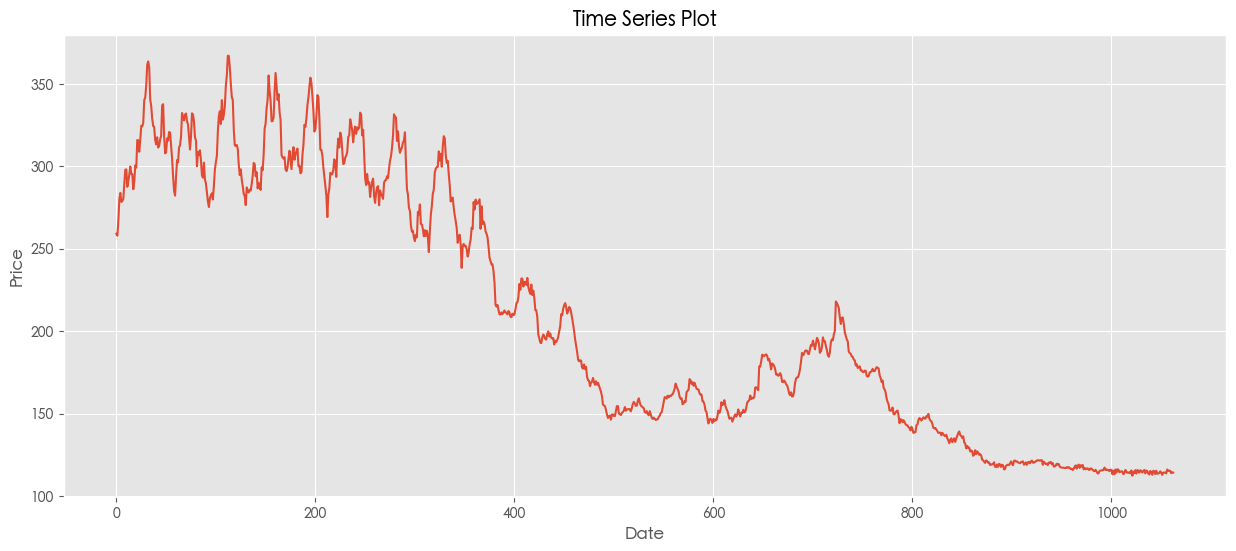

In [30]:
#checking if the data is stationary, thus judging if difference is needed
ADF(ask.Price)
#ask_plt = ask[ask.index <= '1970-01-01 02:00:00']
plt.figure(figsize=(15, 6))
plt.plot(ask.adjusted_time_hours, ask['Price'], linestyle='-',linewidth = 1.5)
plt.title('Time Series Plot')
plt.xlabel('Date')
plt.ylabel('Price')
plt.grid(True)
plt.savefig('timeseries.png')
plt.show()

0      259.05878
1      257.92273
2      266.82759
3      280.17647
4      283.92644
          ...   
1058   115.22624
1059   115.32450
1060   113.81467
1061   114.35305
1062   114.18095
Name: Price, Length: 1063, dtype: float64
0           NaN
1      -1.13605
2       8.90485
3      13.34888
4       3.74997
         ...   
1058    0.00160
1059    0.09826
1060   -1.50983
1061    0.53839
1062   -0.17210
Name: Price, Length: 1063, dtype: float64


AttributeError: 'Series' object has no attribute 'Price'

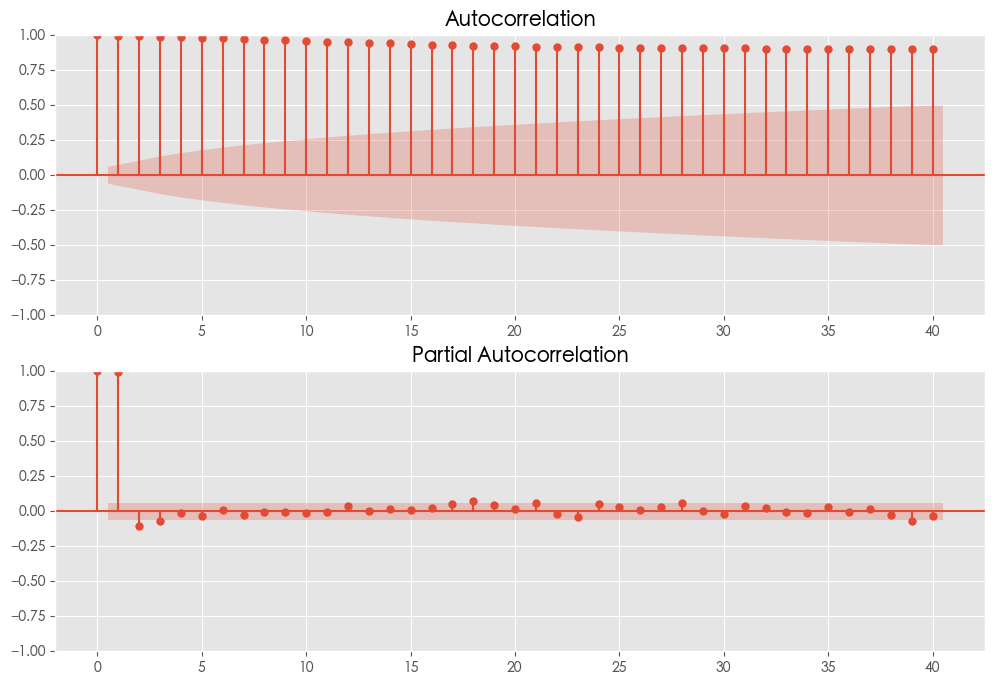

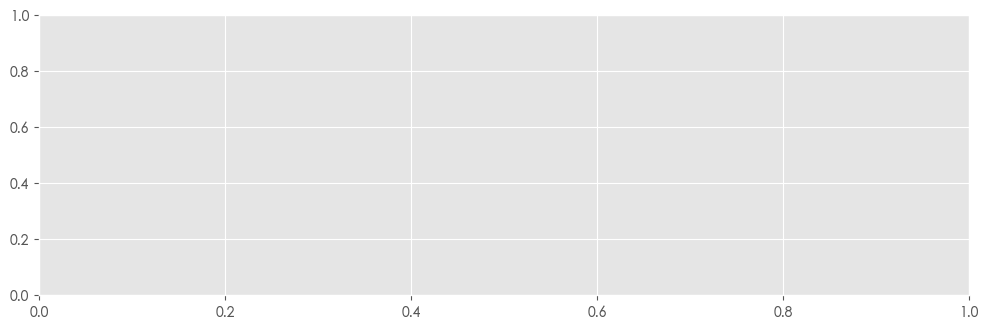

In [32]:
#differenciate
fig = plt.figure(figsize=(12,8))
ax1=fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(ask.Price,lags=40,ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(ask.Price,lags=40,ax=ax2)
ask_price = ask.Price
print(ask_price)
ask_diff = ask_price.diff()
print(ask_diff)
fig = plt.figure(figsize=(12,8))
ax1=fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(ask_diff.Price,lags=40,ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(ask_diff.Price,lags=40,ax=ax2)

In [72]:
## spliting testing set and training set
tape0701_test = tape0701_arima.tail(n=5000)
tape0701_train = tape0701_arima.drop(tape0701_arima.index[-5000:])
tape0701_test

,price
time,
1970-01-01 07:06:37,109.00000
1970-01-01 07:06:38,109.00000
1970-01-01 07:06:39,109.00000
1970-01-01 07:06:40,109.00000
1970-01-01 07:06:41,109.00000
...,...
1970-01-01 08:29:52,109.00000
1970-01-01 08:29:53,109.00000
1970-01-01 08:29:54,109.00000


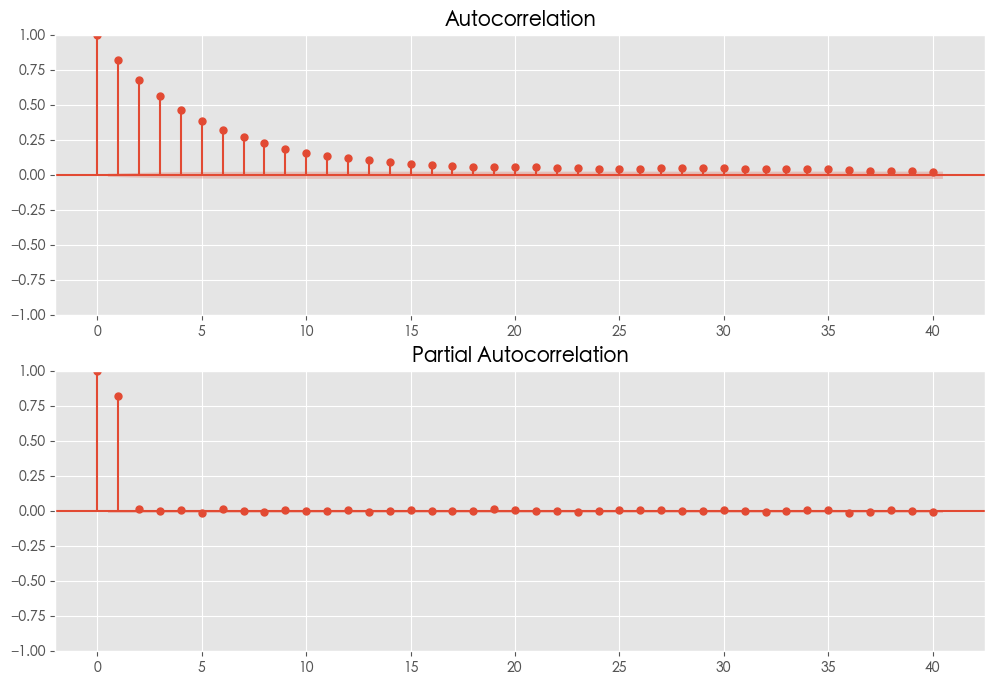

In [67]:
#from acf and pacf we can decide parameter p and q. 
#I may have insufficient understanding towards this part, so it needs further modification
fig = plt.figure(figsize=(12,8))
ax1=fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(tape0701_arima.price,lags=40,ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(tape0701_arima.price,lags=40,ax=ax2)

In [76]:
#normally there are several paramater sets that needs comparing using the following three evaluation metrics, the smaller the better
tape0701_train.index.freq = 'S'
arma_mod20 = sm.tsa.ARIMA(tape0701_train.price,order = (1,1,0)).fit() # data["xt"]是没有差分的数据
arma_mod30 = sm.tsa.ARIMA(tape0701_train.price,order = (0,1,1)).fit()
arma_mod40 = sm.tsa.ARIMA(tape0701_train.price,order = (1,1,1)).fit()
values = [[arma_mod20.aic,arma_mod20.bic,arma_mod20.hqic],[arma_mod30.aic,arma_mod30.bic,arma_mod30.hqic],[arma_mod40.aic,arma_mod40.bic,arma_mod40.hqic]]
df = pd.DataFrame(values,index=["AR(1,1,0)","MA(0,1,1)","ARMA(1,1,1)"],columns=["AIC","BIC","hqic"])
df

,AIC,BIC,hqic
"AR(1,1,0)",109713.02028,109729.32027,109718.29017
"MA(0,1,1)",109646.85584,109663.15583,109652.12573
"ARMA(1,1,1)",107648.06476,107672.51475,107655.96960


In [70]:
#model fitting
result = sm.tsa.ARIMA(tape0701_train.price, order = (1,0,1)).fit()
print(result.summary())

/Users/gali/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency S will be used.
  self._init_dates(dates, freq)
/Users/gali/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency S will be used.
  self._init_dates(dates, freq)
/Users/gali/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency S will be used.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                  price   No. Observations:                25592
Model:                 ARIMA(1, 0, 1)   Log Likelihood              -53818.298
Date:                Sun, 03 Mar 2024   AIC                         107644.596
Time:                        12:26:27   BIC                         107677.197
Sample:                    01-01-1970   HQIC                        107655.136
                         - 01-01-1970                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        108.1933      0.082   1314.817      0.000     108.032     108.355
ar.L1          0.8316      0.003    260.486      0.000       0.825       0.838
ma.L1         -0.0239      0.006     -4.082      0.0

In [ ]:
#ARMA model, unavailable for some reason

arma_mod20 = smt.ARMA(tape0701_test.price,(1,0)).fit() 
print(arma_mod20.aic,arma_mod20.bic,arma_mod20.hqic)
arma_mod30 = sm.tsa.ARMA(tape0701_test.price,(0,1)).fit()
print(arma_mod30.aic,arma_mod30.bic,arma_mod30.hqic)
arma_mod40 = sm.tsa.ARMA(tape0701_test.price,(1,1)).fit()
print(arma_mod40.aic,arma_mod40.bic,arma_mod40.hqic)

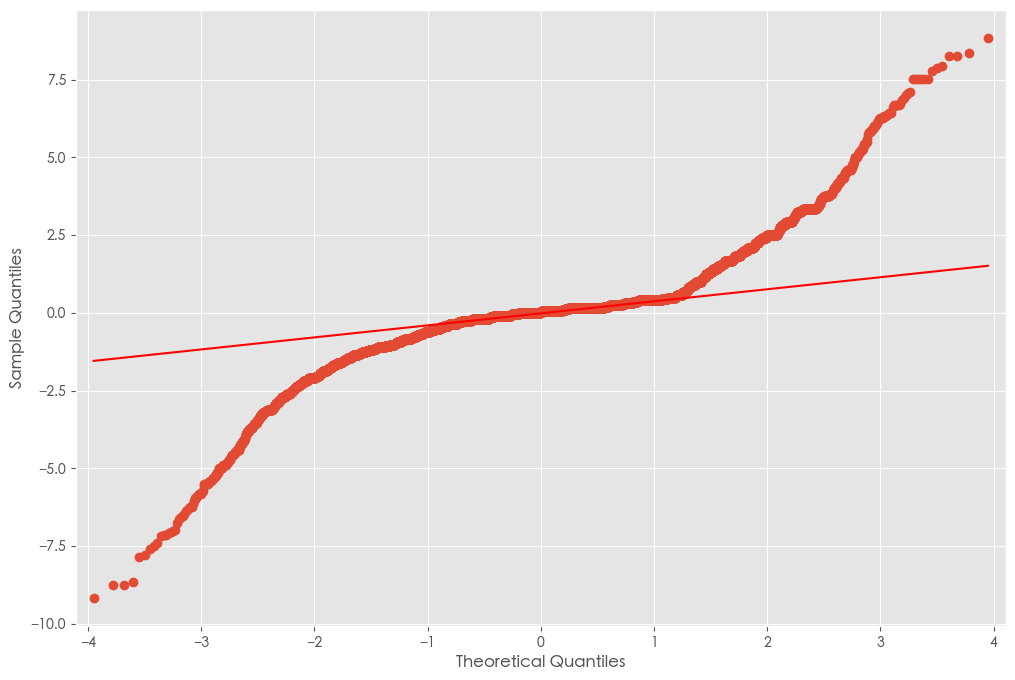

In [71]:
#model evaluation using residual, this is not an ideal outcome
resid = result.resid
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111)
fig = qqplot(resid, line='q', ax=ax, fit=True)

In [73]:
#prediction
pred = result.predict('1970-01-01 07:06:37', '1970-01-01 08:29:56',dynamic=True, typ='levels')
print (pred)

1970-01-01 07:06:37   108.76187
1970-01-01 07:06:38   108.66610
1970-01-01 07:06:39   108.58646
1970-01-01 07:06:40   108.52024
1970-01-01 07:06:41   108.46517
                         ...   
1970-01-01 08:29:52   108.19329
1970-01-01 08:29:53   108.19329
1970-01-01 08:29:54   108.19329
1970-01-01 08:29:55   108.19329
1970-01-01 08:29:56   108.19329
Freq: S, Name: predicted_mean, Length: 5000, dtype: float64


#showprediction
plt.figure(figsize=(12, 8))
plt.xticks(rotation=45)
plt.plot(pred)
plt.plot(tape0701_test.price)
plt.show()